<a href="https://colab.research.google.com/github/MichaelGajhede/superdex_75_calibration/blob/main/superdex_75_calib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SEC Calibration: $\log(MW)$ vs. $K_{av}$

In size exclusion chromatography (SEC), the elution behavior of molecules is related to their size in solution. While elution volume ($V_e$) is the most common parameter, $K_{av}$ can also be used.

### 1. Understanding $K_{av}$

The parameter $K_{av}$ represents the fraction of the stationary phase accessible to a solute molecule:

$\
K_{av} = \frac{V_e - V_o}{V_t - V_o}
\$

Where:

* $V_e$ = Elution volume
* $V_o$ = Void volume
* $V_t$ = Total column volume

### 2. Calibration Procedure

1.  **Run Standards:** Inject standards with known molecular weights ($M$).
2.  **Measure $V_e$:** Determine the elution volume for each standard.
3.  **Determine $V_o$ and $V_t$:**
    * $V_o$: Elution volume of a very large molecule.
    * $V_t$: Column volume (from dimensions or manufacturer).
4.  **Calculate $K_{av}$:** Calculate $K_{av}$ for each standard.
5.  **Plot Calibration Curve:** Plot $\log(M)$ vs. $K_{av}$.
6.  **Fit the Data:** Fit the data to a function (e.g., polynomial, usually just a straight line):

    $
    \log(M) = a_0 + a_1 K_{av} + a_2 K_{av}^2 + ... + a_n K_{av}^n
    $

    Where $a_i$ are constants.

### 3. Using the Calibration Curve

For an unknown sample:

1.  Measure $V_e$.
2.  Calculate $K_{av}$.
3.  Determine $M_{unknown}$:

    $\
    M_{unknown} = 10^{(a_0 + a_1 K_{av,unknown} + a_2 K_{av,unknown}^2 + ... + a_n K_{av,unknown}^n)}
    \$

### 4. Advantages of $k_{avg}$

* Normalized parameter.
* Direct measure of stationary phase accessibility.

### 5. Considerations

* Same precautions as with $V_e$ calibration.
* Accurate $V_o$ and $V_t$ are crucial.
* Empirical relationship, requires a suitable fit.


In [11]:
import pandas as pd

# Superdex 75 10/300 GL column characteristics
V0 = 8  # Superdex 75 10/300 increase void volume
Vcol = 24  # Superdex 75 10/300 increase total volume


# Data extracted from the standards image in column manual using gemini.google.com
data = {
    'Sample': [
        '1. BSA (Mr 67 000) 8 mg/ml',
        '2. Ovalbumin (Mr 43 000) 2.5 mg/ml',
        '3. Ribonuclease A (Mr 13 700) 5 mg/ml',
        '4. Aprotinin (Mr 6 512) 2 mg/ml',
        '5. Vitamin B12 (Mr 1 355) 0.1 mg/ml'
    ],
    'Elution Volume (ml)': [8.2,9.6,11.4,13.1,19.1]
}

# Create the DataFrame
df_standards = pd.DataFrame(data)


# Extract the number from within the parentheses
df_standards['MW (Mr)'] = df_standards['Sample'].str.extract(r'Mr\s(\d+)')

# Convert the extracted 'MW (Mr)' column to numeric and convert from kDa to Da
df_standards['MW (Mr)'] = pd.to_numeric(df_standards['MW (Mr)']) * 1000

# Print the DataFrame
print(df_standards)


                                  Sample  Elution Volume (ml)  MW (Mr)
0             1. BSA (Mr 67 000) 8 mg/ml                  8.2    67000
1     2. Ovalbumin (Mr 43 000) 2.5 mg/ml                  9.6    43000
2  3. Ribonuclease A (Mr 13 700) 5 mg/ml                 11.4    13000
3        4. Aprotinin (Mr 6 512) 2 mg/ml                 13.1     6000
4    5. Vitamin B12 (Mr 1 355) 0.1 mg/ml                 19.1     1000


Sample eluting at 10.00 ml has a molecular weight of 29356.76 Da


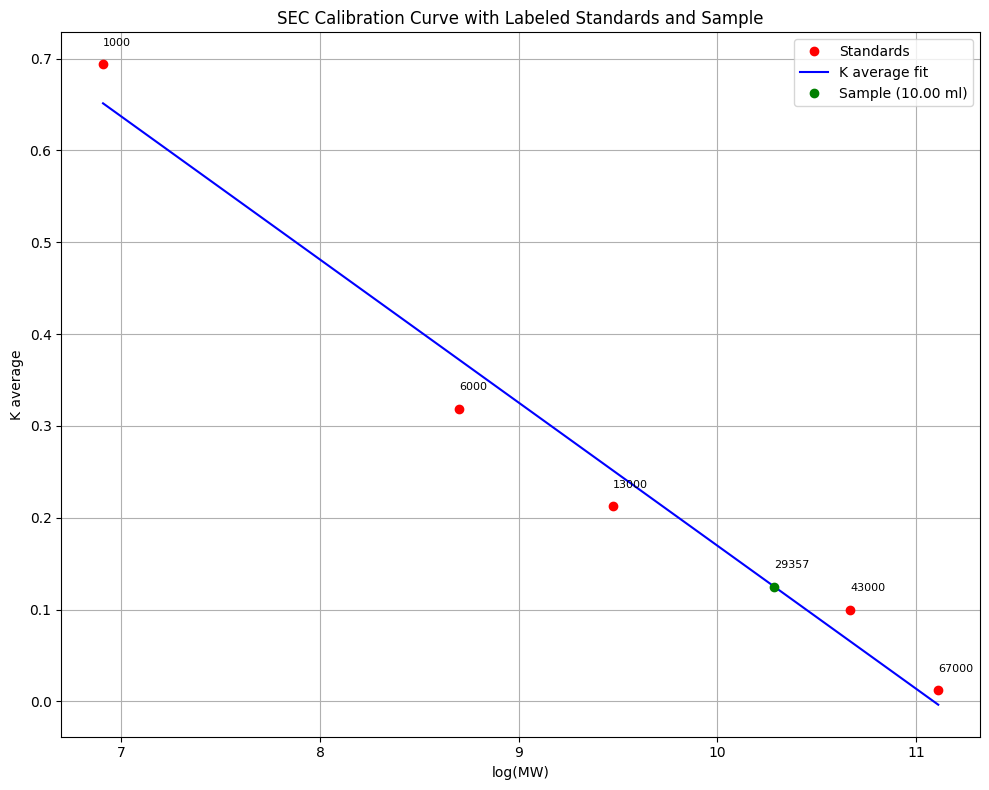

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def calculate_kav(elution_volume, void_volume, total_volume):
    """Calculates Kav (distribution coefficient)."""
    return (elution_volume - void_volume) / (total_volume - void_volume)

def linear_fit(x, a, b):
    """Defines a linear function for fitting."""
    return a * x + b


# Calculate Kav for standards
df_standards['K average'] = calculate_kav(df_standards['Elution Volume (ml)'], V0, Vcol)

# Prepare data for fitting
x_standards = np.log(df_standards['MW (Mr)'])
y_standards = df_standards['K average']
mw_standards = df_standards['MW (Mr)'].values  # Get MW values for labels

# Perform the fit
alpha_mw, pcov = curve_fit(linear_fit, xdata=x_standards, ydata=y_standards)
slope, intercept = alpha_mw

# Given sample elution volume
sample_elution_ml = 10

# Calculate Kav for the sample
kav_sample = calculate_kav(sample_elution_ml, V0, Vcol)

# Calculate log(MW) of the sample using the calibration curve
log_mw_sample = (kav_sample - intercept) / slope

# Calculate MW of the sample
mw_sample = np.exp(log_mw_sample)
print(f'Sample eluting at {sample_elution_ml:.2f} ml has a molecular weight of {mw_sample:.2f} Da')

# Visualize the data and the fit, including labels
plt.figure(figsize=(10, 8))  # Adjust figure size
plt.plot(x_standards, y_standards, 'ro', label='Standards')
plt.plot(x_standards, linear_fit(x_standards, slope, intercept), 'b-', label='K average fit')

# Plot the sample
plt.plot(log_mw_sample, kav_sample, 'go', label=f'Sample ({sample_elution_ml:.2f} ml)')

# Add labels for standards
for i, (x, y, mw) in enumerate(zip(x_standards, y_standards, mw_standards)):
    plt.text(x, y + 0.02, f'{mw:.0f}', fontsize=8)  # Adjust offset and fontsize as needed

# Add label for sample
plt.text(log_mw_sample, kav_sample + 0.02, f'{mw_sample:.0f}', fontsize=8)

plt.xlabel('log(MW)')
plt.ylabel('K average')
plt.title('SEC Calibration Curve with Labeled Standards and Sample')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
